In [17]:
import flopy
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from flopy.utils.gridgen import Gridgen 
import shapefile as sp
import geopandas
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

OSError: Could not find lib geos_c.dll or load any of its variants ['C:\\Users\\emmal\\Anaconda3\\Library\\lib\\geos_c.dll'].

In [4]:

# spatial parameters

Lx = 100.
Ly = 100.
nlay = 2
nrow = 31
ncol = 31
delr = Lx / ncol
delc = Ly / nrow
h0 = 10
h1 = 5
top = h0
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
botm[1, :, :] = -10.

# discretization

ms = flopy.modflow.Modflow(rotation=-10.)
dis = flopy.modflow.ModflowDis(ms, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm)

# creation du workspace
model_ws = os.path.join('.', 'data')
g = Gridgen(dis, model_ws=model_ws,exe_name="../../exe/Gridgen.exe")


In [5]:
model_name="gridgen"
# create simulation
sim = flopy.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws="data")

# create tdis package
tdis_rc = [(1, 1, 1)]
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname="model_name",
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

In [6]:
# setup the active domain
adshp = os.path.join(model_ws, 'ad0')
adpoly = [[[(0, 0), (0, 60), (40, 80.5), (60, 0),(0,0)]]]
#g.add_active_domain(adpoly, range(nlay))

In [7]:
adpoly

[[[(0, 0), (0, 60), (40, 80.5), (60, 0), (0, 0)]]]

In [8]:
#refinement of random points in the grid
x = Lx * np.random.random(10)
y = Ly * np.random.random(10)
wells = list(zip(x, y))
g.add_refinement_features(wells, 'point', 3, range(nlay))
rf0shp = os.path.join(model_ws, 'rf0')

In [9]:
#refinement of a river
river = [[[(-20, 10), (60, 60),(80,20)]]]
g.add_refinement_features(river, 'line', 3, range(nlay))
# add_refinement_features (coord, type of geometry, level of refinement, on which layer)
rf1shp = os.path.join(model_ws, 'rf1')


In [10]:
# refinement of a polygon
g.add_refinement_features(adpoly, 'polygon', 1, range(nlay))
rf2shp = os.path.join(model_ws, 'rf2')


In [11]:
# create a circle of a certain radius
def make_circle (r,steps=360, cx=nrow*delr/2,cy=nrow*delr/2):
    a = np.arange(0,1*np.pi,1*np.pi/steps)
    x = r*np.cos(a)
    y = r*np.sin(a)
    x = np.hstack((x,np.flipud(x[:-1])))
    y = np.hstack((y,-y[:-1]))
    return x+cx,y+cy

#refinement of a well given a certain position cx,cy

#x1,y1=make_circle(r=10,cx=90,cy=80)
#g.add_refinement_features([[list(zip(x1,y1))]], 'polygon', 1, range(nlay))
#rf1shp = os.path.join("data", 'rf1')

def well_refinement (r=1,cx=90,cy=80,level=3,ext=0.5):
    for i in range (level):
        x,y = make_circle(r=r*(ext*i+0.5),cx=cx,cy=cy)
        g.add_refinement_features([[list(zip(x,y))]], 'polygon', level-i, range(nlay))

well_refinement(r=delr,cx=80,cy=50,ext=0.8)
rf3shp = os.path.join(model_ws, 'rf3')
rf4shp = os.path.join(model_ws, 'rf4')

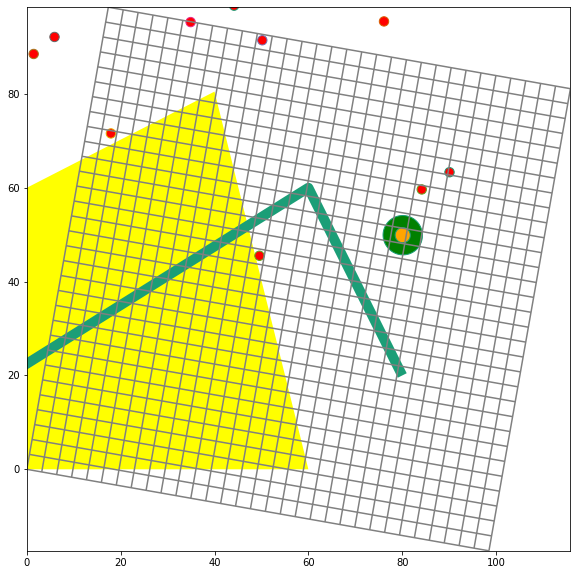

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_grid()
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='yellow', edgecolor='none')
flopy.plot.plot_shapefile(rf1shp, ax=ax, linewidth=10,facecolor="none")
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor='red', radius=1)
flopy.plot.plot_shapefile(rf4shp, ax=ax, facecolor='green', radius=1)
flopy.plot.plot_shapefile(rf3shp, ax=ax, facecolor='orange', radius=3)

In [13]:
g.build() # apply refinement

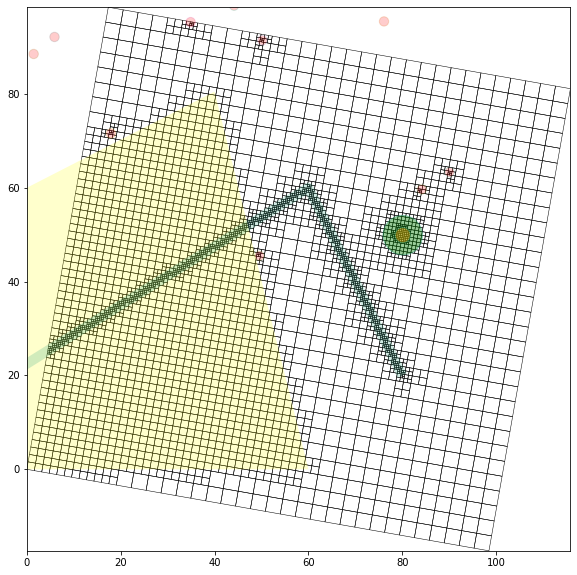

In [14]:
#plot refinement

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5)
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='yellow', edgecolor='none',alpha=0.2)
flopy.plot.plot_shapefile(rf1shp, ax=ax, linewidth=10,facecolor="none",alpha=0.2)
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor='red', radius=1,alpha=0.2)
flopy.plot.plot_shapefile(rf4shp, ax=ax, facecolor='green', radius=1,alpha=0.4)
flopy.plot.plot_shapefile(rf3shp, ax=ax, facecolor='orange', radius=3,alpha=0.4)

In [13]:
# get infos to create a disv package

gridprops = g.get_gridprops_disv()
ncpl = gridprops['ncpl']
top = gridprops['top']
botm = gridprops['botm']
nvert = gridprops['nvert']
vertices = gridprops['vertices']
cell2d = gridprops['cell2d']


In [14]:
#g.get_gridprops_disu6()
#get info to make a disu package

## intersections

In [15]:
#interesct of polygon and grid

adpoly_intersect = g.intersect(adpoly, 'polygon', 0)
print(adpoly_intersect.dtype.names)
print(adpoly_intersect)
print(adpoly_intersect.nodenumber)

('nodenumber', 'polyid', 'totalarea', 'SHAPEID')
[( 283, 0, 2.60146 , 0) ( 293, 0, 2.60146 , 0) ( 361, 0, 2.60146 , 0) ...
 (3495, 0, 0.235705, 0) (3544, 0, 1.3039  , 0) (3497, 0, 1.91975 , 0)]
[ 283  293  361 ... 3495 3544 3497]


In [16]:
# intersection of wells and grid

well_intersect = g.intersect(wells, 'point', 0)
print(well_intersect.dtype.names)
print(well_intersect)
print(well_intersect.nodenumber)

('nodenumber', 'pointid', 'SHAPEID')
[(2755, 0, 0) ( 250, 1, 1) (2231, 2, 2) (3082, 3, 3) ( 180, 5, 5)
 (3376, 8, 8) ( 223, 9, 9)]
[2755  250 2231 3082  180 3376  223]


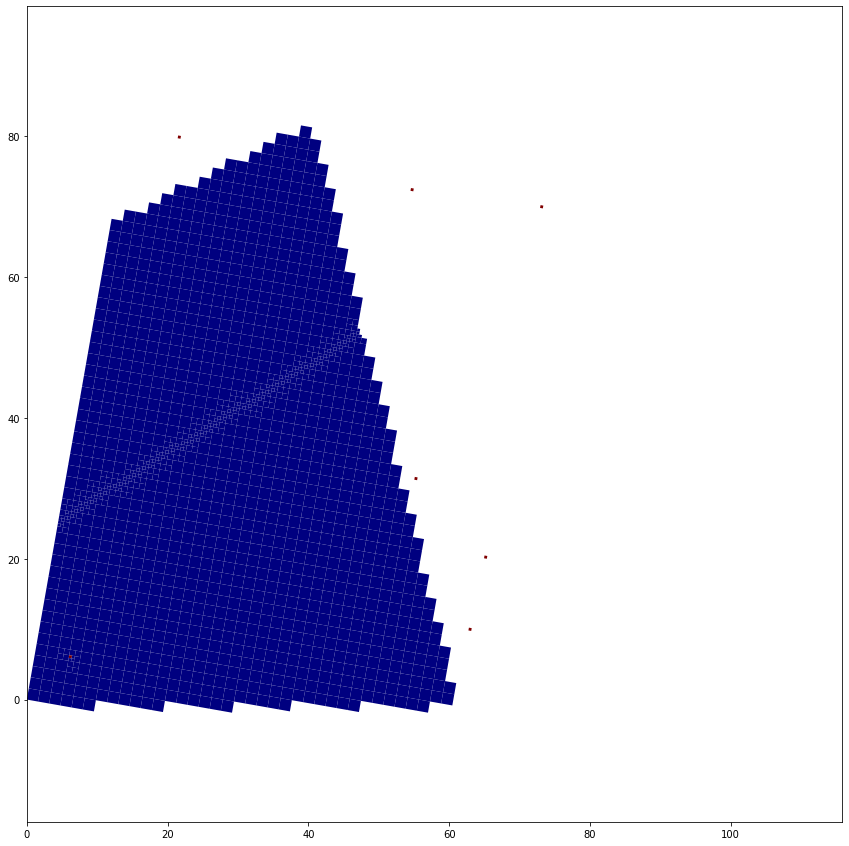

In [20]:

a = np.zeros((4999), dtype=np.int)
a[adpoly_intersect.nodenumber] = 1
a[well_intersect.nodenumber] = 2
#a[river_intersect.nodenumber] = 3
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, a=a, masked_values=[0], edgecolor='none', cmap='jet')
#flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='yellow', alpha=0.25)